## 00. Coding Best Practices

In [1]:
# Basic libraries
import pandas as pd # data manipulatioN
import numpy as np # numerical operations
import matplotlib.pyplot as plt # 2D visualizations
import seaborn as sns # high-resolution visualization
import warnings # warning messages management

# SQL connection
from getpass import getpass # SQL connector
from sqlalchemy import create_engine # route to the engine

# Machine Learning
from sklearn.preprocessing import LabelEncoder # label encoding
from sklearn.model_selection import train_test_split # splitting data into train/test sets
from sklearn.linear_model import LogisticRegression # logistic model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay # logistic metrics
from sklearn import metrics # moar metrics

# Settings
pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings

In [2]:
# Basic functions
def data_info(data): # improved data.info()
    print(f"Data shape is {data.shape}.")
    print()
    print("Data row sample and full columns:")
    return data.sample(5)

## 01 - Getting the Data

In [5]:
# Creating a safe connection
password = getpass("Please, kindly insert your password:")
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'

Please, kindly insert your password:········


In [6]:
# Getting the data
engine = create_engine(connection_string)
data = pd.read_sql_query('SELECT * FROM logistic_data;', engine)

In [7]:
data_info(data)

Data shape is (1000, 8).

Data row sample and full columns:


,film_id,rental_duration,rental_rate,length,rating,special_features,name,n_rentals
591,302,5,2.99,131,G,Commentaries,Games,19.0
146,343,6,2.99,94,PG,"Trailers,Deleted Scenes",Children,5.0
211,445,5,2.99,100,G,"Trailers,Deleted Scenes",Classics,25.0
66,36,7,0.99,127,PG-13,"Trailers,Commentaries",Animation,NaN
362,888,5,4.99,53,PG-13,Behind the Scenes,Documentary,11.0


<div class="alert alert-block alert-success">
    
**First impression:**
    
_____________

The following database is a collection of over **one-year** (from 2005/05/24 to 2006/02/14) 1.000 film's information among 8 different columnns.
    
Our **binary target** will the probability of a movie being rented again or not in the future (low or high) --> We will therefore classify movies based on low/high (binary) demand renting rate by analyzing the total number of rentals for each film within the time period (n_rentals)
    
**Firstly**, data cleaning:
    
_____________
</div>

## 02 - Cleaning the Data

In [8]:
# copy as best practices
data_copy = data.copy()

### Encoding
<div class="alert alert-block alert-info">
    
* We imported features such as `rating`, `special_features` and `name` as categoricals, we will use LabelEncoder to encode them to numericals:
</div>

In [9]:
# Initialize the LabelEncoder object from sklearn
le = LabelEncoder()

# Fit and transform the data frame column
data_copy['rating_ecd'] = le.fit_transform(data_copy['rating'])
data_copy['special_features_ecd'] = le.fit_transform(data_copy['special_features'])
data_copy['name_ecd'] = le.fit_transform(data_copy['name'])

# Visualizing the changes
data_encoded_f = data_copy[['rating_ecd', 'special_features_ecd', 'name_ecd']]
data_comparision_2 = pd.concat([data_encoded_f, data_copy[['rating', 'special_features', 'name']]], axis=1)
data_comparision_2.sample(5)

,rating_ecd,special_features_ecd,name_ecd,rating,special_features,name
838,2,5,13,PG,Deleted Scenes,Sci-Fi
340,2,0,5,PG,Behind the Scenes,Documentary
43,2,13,0,PG,"Trailers,Deleted Scenes",Action
715,1,4,11,NC-17,"Commentaries,Deleted Scenes,Behind the Scenes",Music
484,2,0,7,PG,Behind the Scenes,Family


### Selecting numericals features / Dealing with Null values

<div class="alert alert-block alert-info">
    
* We will now select all numericals from `data_copy` to drop the categoricals.
* Also, we will use `.fillna(0)` to deal with NaN values from the LEFT JOIN with n_rental (explained in [SQL database-extraction](https://github.com/isi-mube/iron-labs/blob/main/unit_3_sql/lab-predictions-logistic-regression/notebook/sql_database_extraction_process.sql))
</div>

In [10]:
# Create a new dataframe with only the numerical columns using select_dtypes
X_N = data_copy.select_dtypes(np.number).fillna(0) # we also deal with NaN values
X_N.sample(10)

,film_id,rental_duration,rental_rate,length,n_rentals,rating_ecd,special_features_ecd,name_ecd
92,430,7,0.99,49,13.0,0,10,1
539,467,6,0.99,181,19.0,0,5,8
150,370,4,2.99,108,18.0,4,6,2
4,56,6,2.99,129,18.0,0,9,0
61,968,6,4.99,79,14.0,0,8,0
463,419,4,2.99,141,0.0,0,14,7
790,720,3,2.99,179,20.0,1,14,12
815,81,6,4.99,103,14.0,3,8,13
178,853,3,4.99,139,11.0,0,3,2
517,192,4,4.99,50,0.0,4,4,8


In [11]:
X_N.shape

(1000, 8)

<div class="alert alert-block alert-success">
    
A **cleaned** dataset with `8 features`. Without the target. 
   
</div>

### Feature Engineering (target creation)

<div class="alert alert-block alert-warning">
    
Our target is the probability of a movie being rented again or not in the futre. 
    
--> In a nutshell, which movies have **higher** or **lower** demand.
    
To create our `target`, we will first look at the distribution of `n_rentals` and calculate the `mean` and `median`. Check the [SQL database-extraction](https://github.com/isi-mube/iron-labs/blob/main/unit_3_sql/lab-predictions-logistic-regression/notebook/sql_database_extraction_process.sql) for more information about this process.</div>

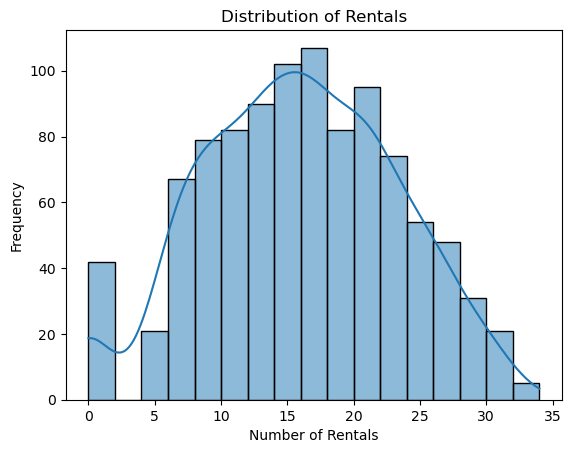

In [12]:
sns.histplot(X_N['n_rentals'], kde=True)
plt.xlabel('Number of Rentals')
plt.ylabel('Frequency')
plt.title('Distribution of Rentals')
plt.show()

<div class="alert alert-block alert-success">

The plot shows a bell-curve distribution, meaning a **normal distribution** of the data. We should expect similar mean and median results.
</div>

In [13]:
# Compute the mean and median of n_rentals
n_rentals_mean = X_N['n_rentals'].mean()
n_rentals_median = X_N['n_rentals'].median()
print(f"Mean = {n_rentals_mean}")
print(f"Median = {n_rentals_median}")

Mean = 15.862
Median = 16.0


<div class="alert alert-block alert-success">

As expected, both average (mean) and the middle value (median) have similar results. We will define our treshold with the **mean** since it's more specific to **get our target**, a binary feature with:
    
* 1 **if** data **is** bigger than `n_rental` mean **else** 0
</div>

In [14]:
X_N['movie_demand'] = [1 if x > n_rentals_mean else 0 for x in data['n_rentals']]

In [15]:
# Our target `movie_demnad` should be automatically to the right
data_headers = list(X_N.columns.values) # to get and check all column names
print("The Column Headers are :", data_headers) 

The Column Headers are : ['film_id', 'rental_duration', 'rental_rate', 'length', 'n_rentals', 'rating_ecd', 'special_features_ecd', 'name_ecd', 'movie_demand']


In [16]:
data_info(X_N)

Data shape is (1000, 9).

Data row sample and full columns:


,film_id,rental_duration,rental_rate,length,n_rentals,rating_ecd,special_features_ecd,name_ecd,movie_demand
586,227,4,4.99,88,18.0,4,3,9,1
903,532,5,4.99,80,15.0,2,6,14,0
978,642,7,2.99,120,0.0,3,6,15,0
391,282,5,0.99,92,19.0,1,7,6,1
514,148,3,2.99,132,0.0,4,10,8,0


<div class="alert alert-block alert-success">

**Now**, we have a cleaned dataset with a target (`movie_demand)`;  `1.000` film's information in `9` distinct numerical features.
</div>

<img src="https://i.imgflip.com/7fx9m2.jpg" title="made at imgflip.com" style="width:350px;height:400px;"/></a><div><a href="https://imgflip.com/memegenerator">from Imgflip Meme Generator</a></div>

## 03 - Exploratory Data Analysis

### Checking for outliers

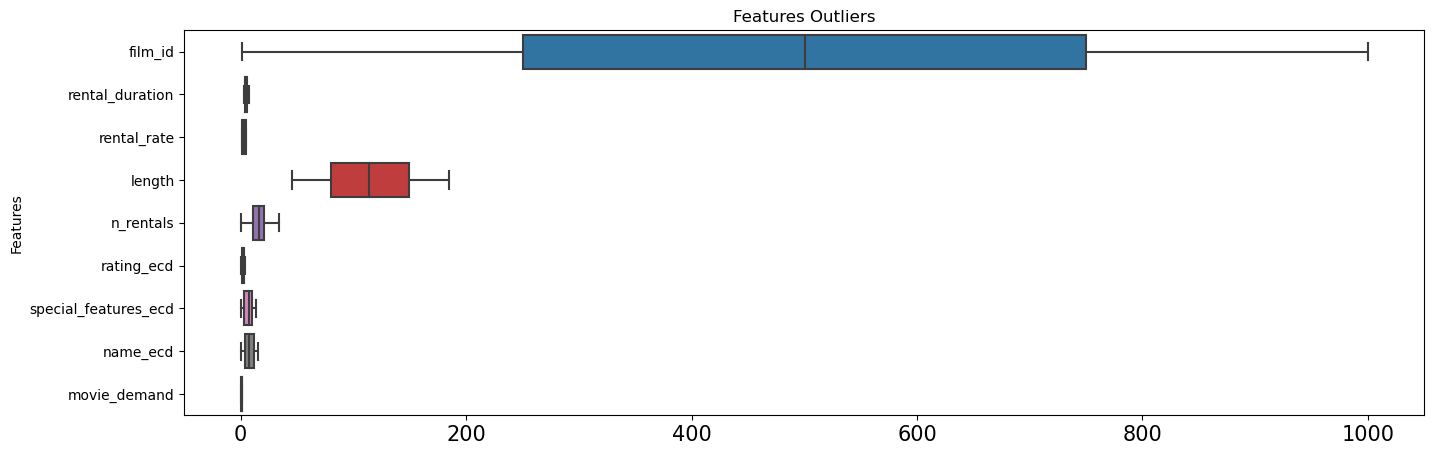

In [17]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(data=X_N, orient="h", ax=ax, showfliers=True, whis=1.5)
ax.set_ylabel("Features") # Set the x-axis label
ax.set_title("Features Outliers") # Set the title of the plot
ax.tick_params(axis='x', labelsize=15) # Adjust the font size of the x-axis ticks
# Show the plot
plt.show()

 <div class="alert alert-block alert-info">

There are not visible outliers. **Meaning**, the data could be normally distributed.<div>

### Checking normal distributions

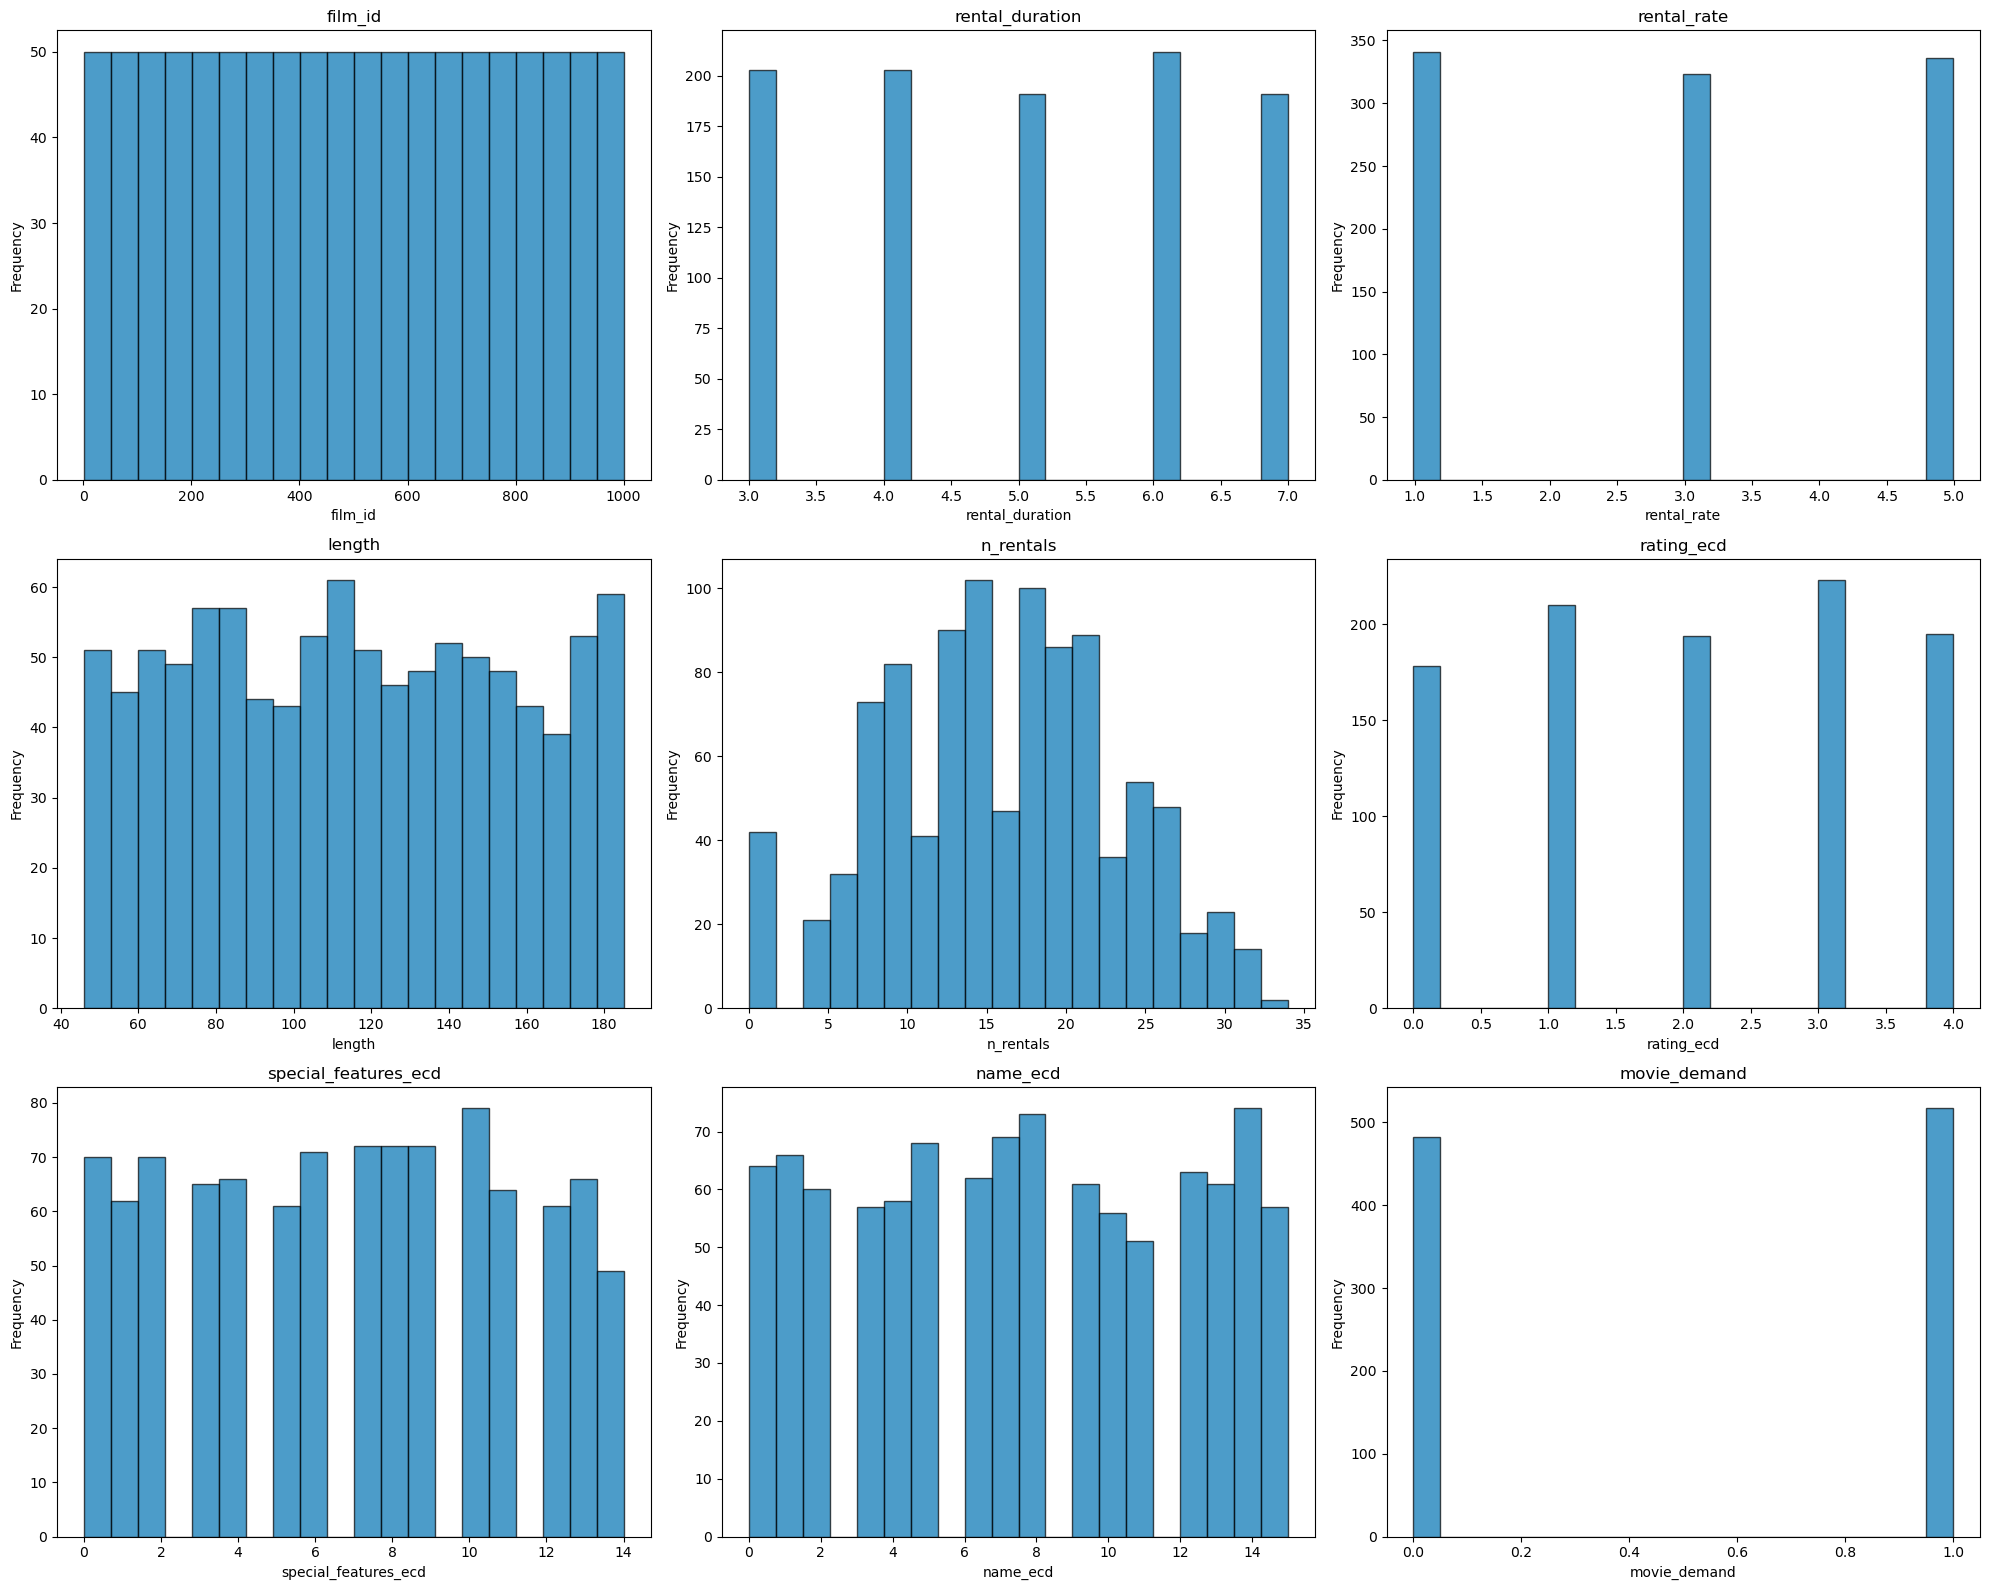

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 16))  # nrows to 3, ncols to 3 to plot our 9 features
color = '#0072B2'  # blue

for i, ax in enumerate(axes.flat):
    if i >= len(X_N.columns):
        break
    ax.hist(X_N.iloc[:, i], color=color, bins=20, alpha=0.7, edgecolor='black')
    ax.set_title(X_N.columns[i])
    ax.set_xlabel(X_N.columns[i])
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">

As expected, data is **normaly distributed**, so we will apply no-transformations. Also, our model, `logistic regression` dosen't need normaly distributed data in the first place.
    
We can also observe how `rental_rate` is divided by 3 categories, same with `movies_demand` (as intended, in 2)<div>

### Dealing with multicollinearity

In [19]:
# Creating the matrix
X_corr = round(X_N.corr(), 4)

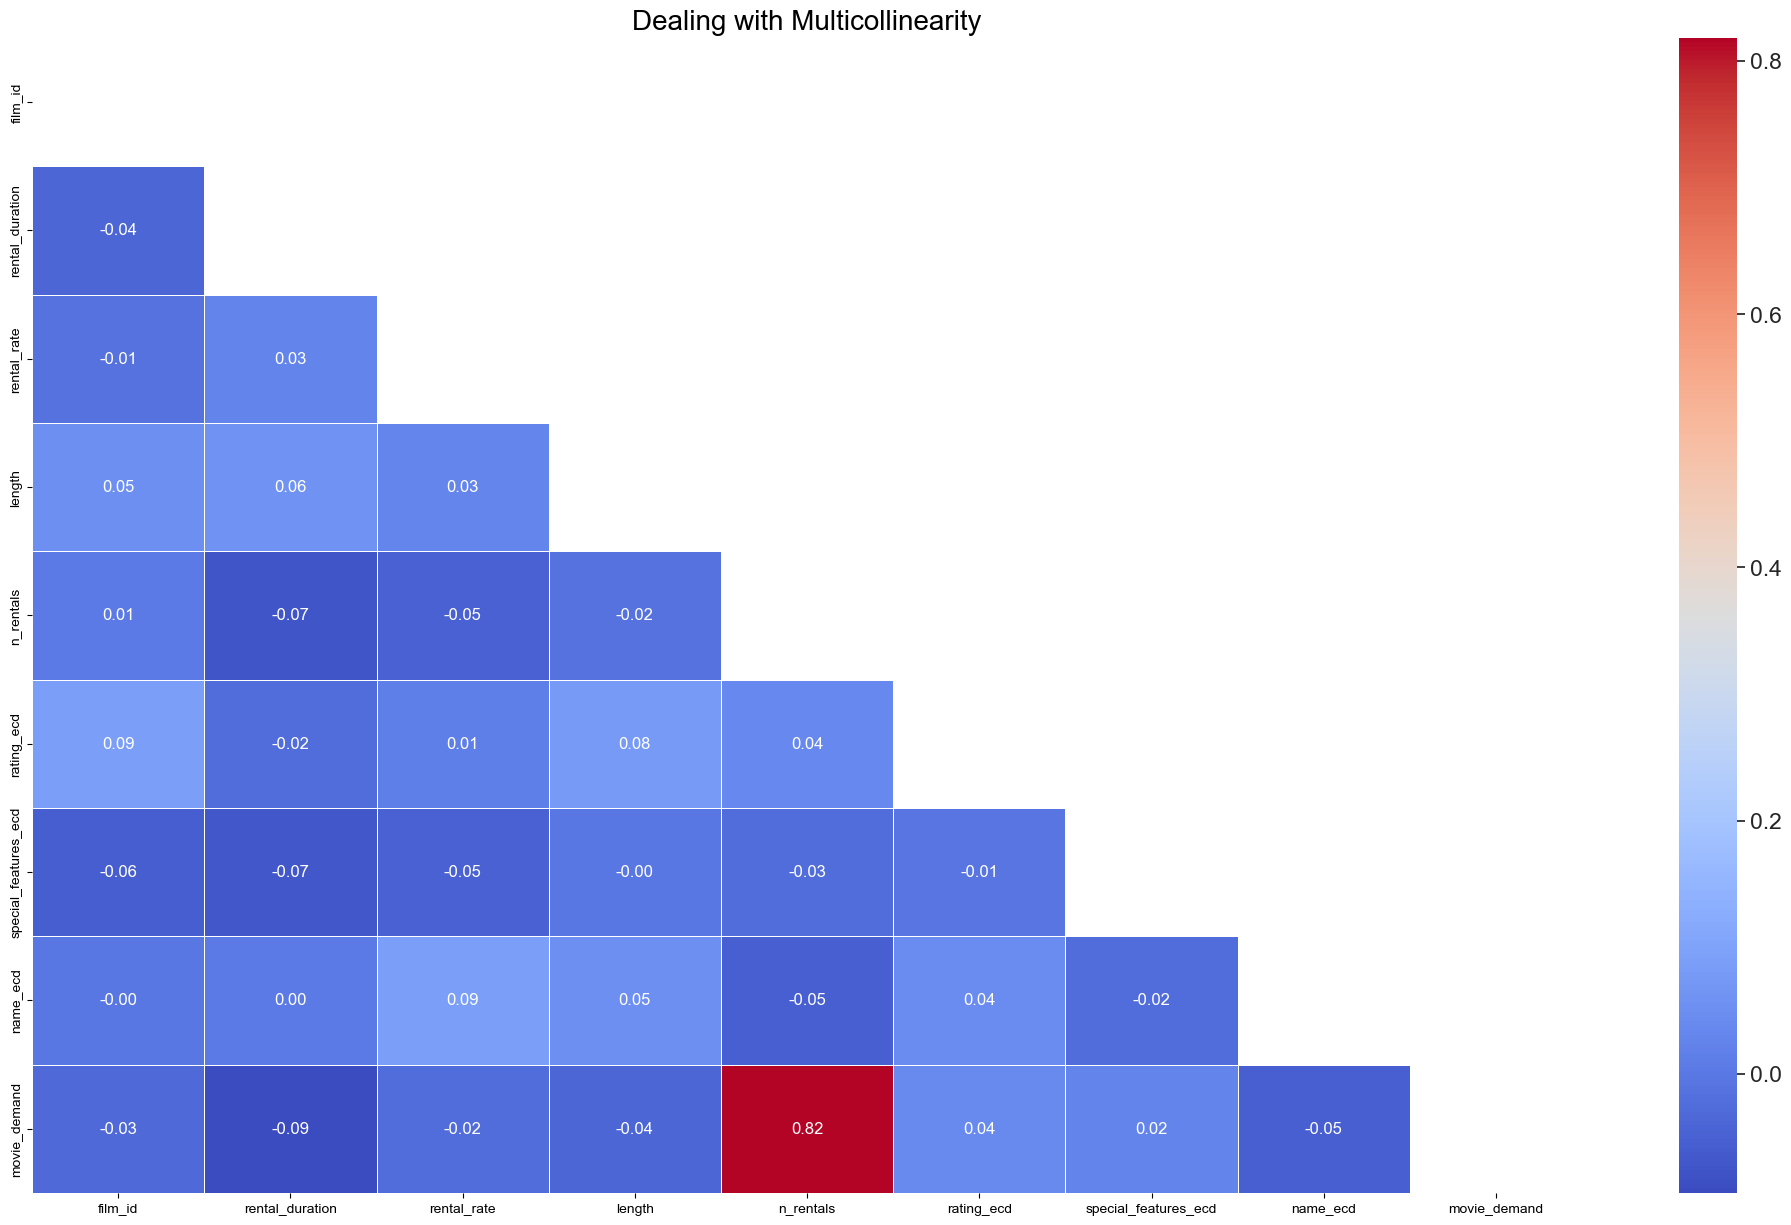

In [20]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(X_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix
f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.5) # increase font size
ax = sns.heatmap(X_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Dealing with Multicollinearity", fontsize=20) # add title
plt.show()

<div class="alert alert-block alert-success">

There is one feature ,`n_rentals`, that shows high correlation with our target `movie_demands` as it could be expected. Also, it does not show multicollinearity with the other features. `name_ecd` and `film_id` also shows great potential, we will look at this features more closely in our exploration.
    
In this process, there is nothing to drop, so we keep with the original dataset shape:
<div>

In [21]:
X_N.shape

(1000, 9)

## 04 - Processing Data

### Normalizing the data

<div class="alert alert-block alert-warning">

For a `logistic regression` there is no need to normalize or scale the data. 

Nothing to do in this process.
<div>

### X-Y Split

In [22]:
# We need to be careful about when and how we do the split.
Y = X_N['movie_demand']
X = X_N.drop(['movie_demand'], axis=1)

## 05 - Modeling

### Train-Test Split

<img src="https://i.imgflip.com/7fxbyk.jpg" title="made at imgflip.com" style="width:400px;height:250px;"/></a><div><a href="https://imgflip.com/memegenerator">from Imgflip Meme Generator</a></div>

In [23]:
# We define train and test for X and Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) 

# test_size = We give 30% for testing and 70% for testing
# random_state = it'll improve the model to divide always the model in the same way

In [24]:
len(X) # Len before the test

1000

In [25]:
len(X_test) # Len after testing 30% of X data

300

In [26]:
len(X_train) # Len after training 70% of X data

700

<img src="https://i.imgflip.com/7fxcen.jpg" title="made at imgflip.com" style="width:250px;height:200px;"/></a><div><a href="https://imgflip.com/memegenerator">from Imgflip Meme Generator</a></div>

### Logistic Regression

In [27]:
# We traing the training dataset using Logistic Regression
logistic = LogisticRegression(random_state=0).fit(X_train, y_train)

<div class="alert alert-block alert-info">
To visualize the predictions, we will count all predicted values.
    
* If the model predicts **1** means the movie has a high demand, and it'll be probably be rented again.
* Else, **0** means the movie has a low demand.<div>

In [28]:
# Predictions
predictions = logistic.predict(X_test)
# Converting the numpy array to panda series
pd.Series(predictions).value_counts()

1    158
0    142
dtype: int64

In [29]:
# We compare it to the true values from historical data
y_test.value_counts()

1    154
0    146
Name: movie_demand, dtype: int64

<div class="alert alert-block alert-success">

Both **predictions** and **true** values look very similar. 
We will make an **accuarcy** & confussion matrix to evaluate the model.
<div>

### Accuaracy evaluation

In [30]:
# Predictions
predictions = logistic.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

#Printing the results
print(f"Accuracy = {accuracy:.2f}")

Accuracy = 0.92


### Confussion matrix evaluation

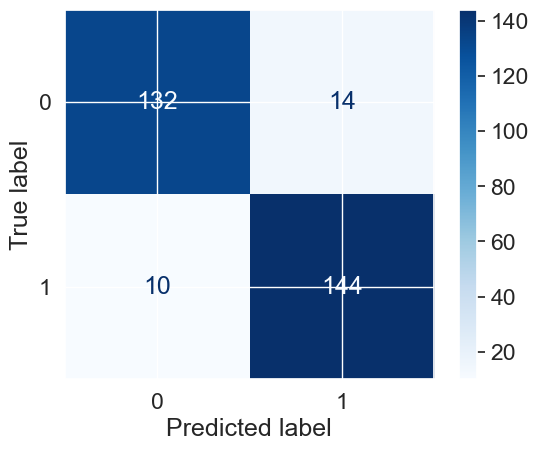

In [31]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

<div class="alert alert-block alert-success">

Our model has:
* **144** True Positives Vs **14** False Positives
* & **132** True Negatives Vs **10** False Negatives
    
And an **accuaracy** of 92%... quite solid!
<div>

## 06 - Reporting

### Presenting the results

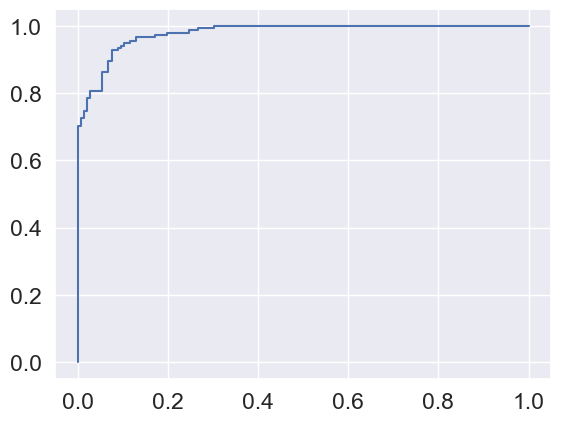

In [32]:
### For the roc curve we need to "binarize" the target (OneVsAll)
y_pred_proba = logistic.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)
plt.show()

### So... Will the movie be rented in the future?

In [33]:
train_predictions = logistic.predict(X_train)
test_predictions = logistic.predict(X_test)

In [34]:
# Add the predicted demand column to the train and test sets
X_train['predicted_demand'] = train_predictions
X_test['predicted_demand'] = test_predictions

In [35]:
# Combine the train and test sets
X_full = pd.concat([X_train, X_test])
X_full['movie_demand'] = pd.concat([y_train, y_test])

In [37]:
# Display the entire dataset with the new predicted_demand column
X_full[['film_id', 'movie_demand', 'predicted_demand']].head(25)

,film_id,movie_demand,predicted_demand
541,493,0,0
440,63,0,0
482,679,1,1
422,803,1,0
778,538,0,0
949,103,1,1
334,466,0,0
576,984,0,0
934,841,1,1
567,821,0,0


<div class="alert alert-block alert-success">

If `predicted_demand` 1 = that movie (film_id) has high probability to be rented again.

We can check `film_id` `652` for example to know the title in a simple querie:<div>

In [41]:
film_title = pd.read_sql_query('SELECT * FROM film WHERE film_id = 652;', engine)
film_title.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,652,PAJAMA JAWBREAKER,A Emotional Drama of a Boy And a Technical Wri...,2006,1,None,3,0.99,126,14.99,R,"Trailers,Deleted Scenes",2006-02-15 05:03:42
